In [47]:
#Importing Libraries

import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

In [2]:
#Loading Data
energy = pd.read_csv('energy.csv')
energy = energy[['day','LCLid','energy_sum']]
energy.reset_index()
energy.head(10)

,day,LCLid,energy_sum
0,2012-10-12,MAC000002,7.098
1,2012-10-13,MAC000002,11.087
2,2012-10-14,MAC000002,13.223
3,2012-10-15,MAC000002,10.257
4,2012-10-16,MAC000002,9.769
5,2012-10-17,MAC000002,10.885
6,2012-10-18,MAC000002,10.751
7,2012-10-19,MAC000002,8.431
8,2012-10-20,MAC000002,17.378
9,2012-10-21,MAC000002,24.490


In [3]:
#Normalizing data so we see energy use by day
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(4)

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


In [4]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [5]:
energy.count()

day           829
energy_sum    829
LCLid         829
dtype: int64

In [6]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [7]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [8]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436003,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


In [9]:
energy.head()

,day,energy_sum,LCLid,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805


In [10]:
weather = pd.read_csv('weatherdata.csv')
weather.day = pd.to_datetime(weather.day,format='%Y-%m-%d').dt.date
weather.head()

,Name,day,Maximum_Temperature,Minimum_Temperature,Temperature,Wind_Chill,Precipitation,Snow,Wind_Speed,Visibility,Cloud_Cover,Relative_Humidity,Conditions
0,"London, England, United Kingdom",2011-11-23,10.6,4.5,7.8,3.2,0.20,NaN,12.4,10.2,0.1,91.90,Rain
1,"London, England, United Kingdom",2011-11-24,13.1,9.0,10.6,7.1,0.24,NaN,22.7,17.6,0.2,88.60,Rain
2,"London, England, United Kingdom",2011-11-25,13.3,7.6,11.1,4.8,1.00,NaN,28.8,24.4,0.2,78.93,Rain
3,"London, England, United Kingdom",2011-11-26,13.1,7.0,10.4,4.5,0.00,NaN,35.5,28.1,0.3,80.80,Clear
4,"London, England, United Kingdom",2011-11-27,14.1,5.1,11.3,4.0,0.50,NaN,34.5,33.7,0.3,70.82,Rain


In [11]:
weather.head()

,Name,day,Maximum_Temperature,Minimum_Temperature,Temperature,Wind_Chill,Precipitation,Snow,Wind_Speed,Visibility,Cloud_Cover,Relative_Humidity,Conditions
0,"London, England, United Kingdom",2011-11-23,10.6,4.5,7.8,3.2,0.20,NaN,12.4,10.2,0.1,91.90,Rain
1,"London, England, United Kingdom",2011-11-24,13.1,9.0,10.6,7.1,0.24,NaN,22.7,17.6,0.2,88.60,Rain
2,"London, England, United Kingdom",2011-11-25,13.3,7.6,11.1,4.8,1.00,NaN,28.8,24.4,0.2,78.93,Rain
3,"London, England, United Kingdom",2011-11-26,13.1,7.0,10.4,4.5,0.00,NaN,35.5,28.1,0.3,80.80,Clear
4,"London, England, United Kingdom",2011-11-27,14.1,5.1,11.3,4.0,0.50,NaN,34.5,33.7,0.3,70.82,Rain


In [12]:
weather = weather.drop(['Name','Snow','Conditions'], axis=1)
weather.head()

,day,Maximum_Temperature,Minimum_Temperature,Temperature,Wind_Chill,Precipitation,Wind_Speed,Visibility,Cloud_Cover,Relative_Humidity
0,2011-11-23,10.6,4.5,7.8,3.2,0.20,12.4,10.2,0.1,91.90
1,2011-11-24,13.1,9.0,10.6,7.1,0.24,22.7,17.6,0.2,88.60
2,2011-11-25,13.3,7.6,11.1,4.8,1.00,28.8,24.4,0.2,78.93
3,2011-11-26,13.1,7.0,10.4,4.5,0.00,35.5,28.1,0.3,80.80
4,2011-11-27,14.1,5.1,11.3,4.0,0.50,34.5,33.7,0.3,70.82


In [13]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(5)

,day,energy_sum,LCLid,avg_energy,Maximum_Temperature,Minimum_Temperature,Temperature,Wind_Chill,Precipitation,Wind_Speed,Visibility,Cloud_Cover,Relative_Humidity
0,2011-11-23,90.385000,13,6.952692,10.6,4.5,7.8,3.2,0.20,12.4,10.2,0.1,91.90
1,2011-11-24,213.412000,25,8.536480,13.1,9.0,10.6,7.1,0.24,22.7,17.6,0.2,88.60
2,2011-11-25,303.993000,32,9.499781,13.3,7.6,11.1,4.8,1.00,28.8,24.4,0.2,78.93
3,2011-11-26,420.976000,41,10.267707,13.1,7.0,10.4,4.5,0.00,35.5,28.1,0.3,80.80
4,2011-11-27,444.883001,41,10.850805,14.1,5.1,11.3,4.0,0.50,34.5,33.7,0.3,70.82


No handles with labels found to put in legend.
No handles with labels found to put in legend.


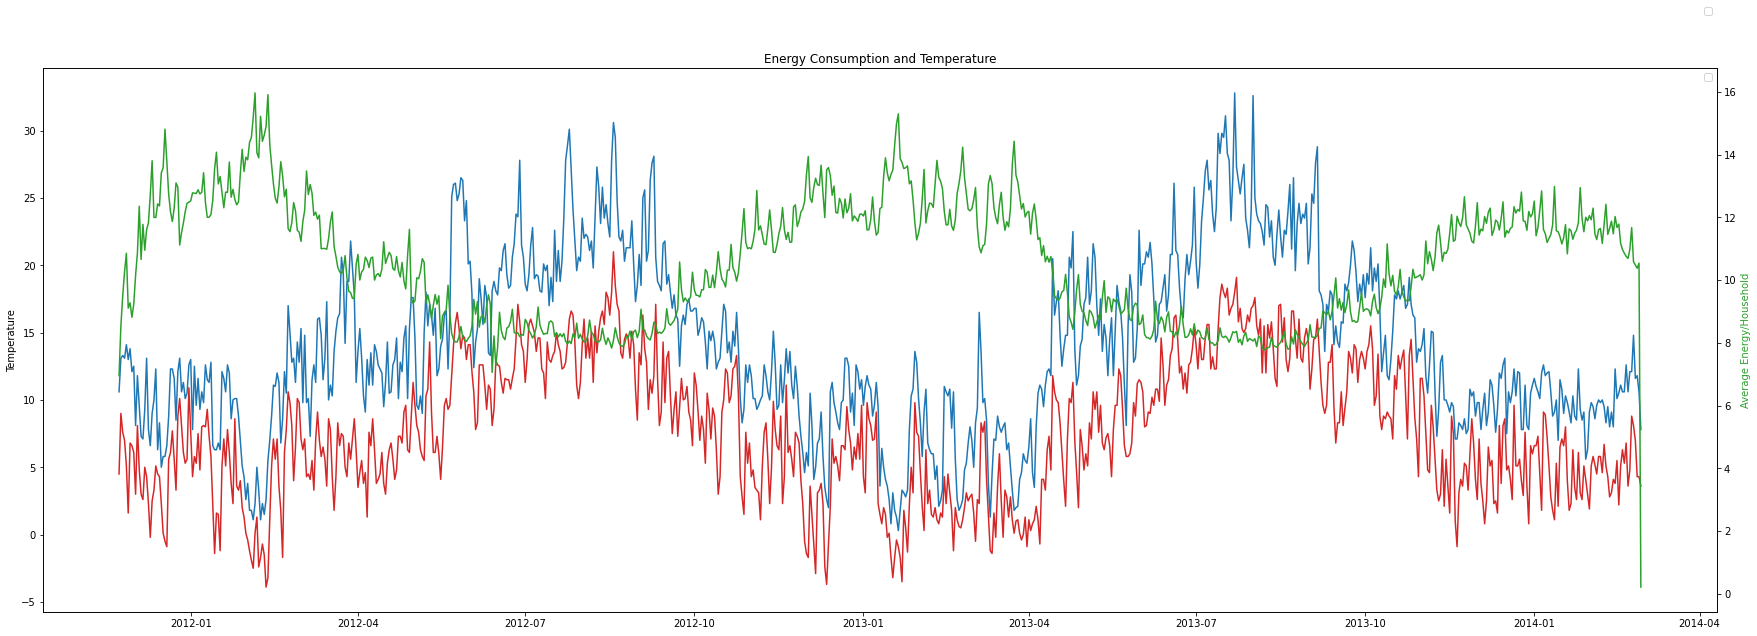

In [14]:
#Temperature vs Energy
fig, ax1 = plt.subplots(figsize = (30,10))
ax1.plot(weather_energy.day, weather_energy.Minimum_Temperature, color = 'tab:red')
ax1.plot(weather_energy.day, weather_energy.Maximum_Temperature, color = 'tab:blue')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
plt.show()

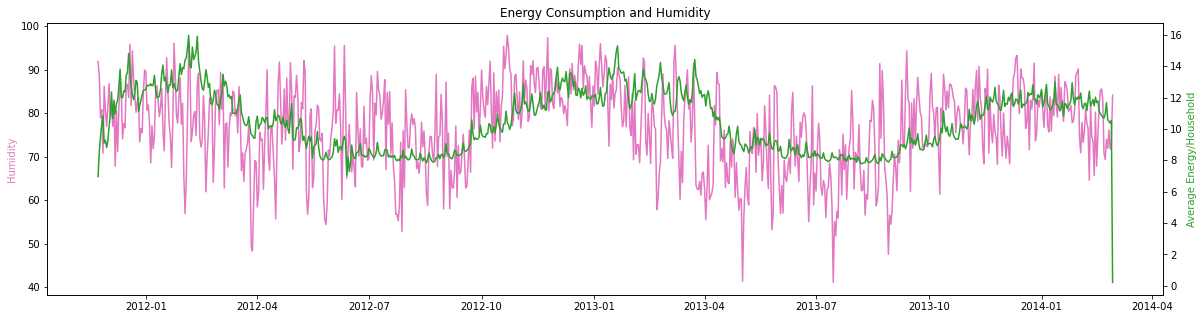

In [15]:
#Humidity vs Energy
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.Relative_Humidity, color = 'tab:Pink')
ax1.set_ylabel('Humidity',color = 'tab:Pink')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Energy Consumption and Humidity')
plt.show()

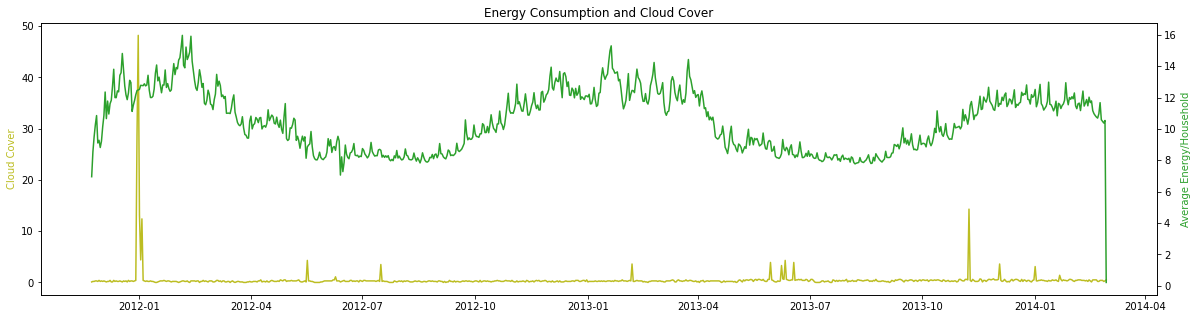

In [16]:
#Cloud Cover vs Energy
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.Cloud_Cover, color = 'tab:Olive')
ax1.set_ylabel('Cloud Cover',color = 'tab:Olive')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Energy Consumption and Cloud Cover')
plt.show()

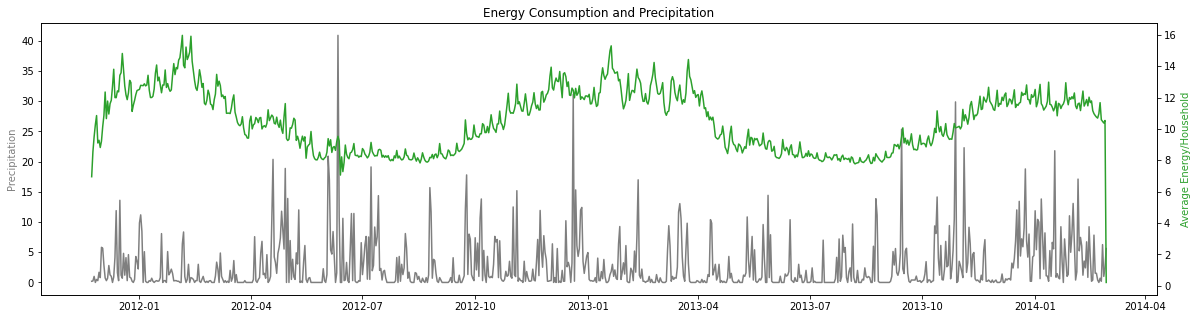

In [17]:
#Precipitation vs Energy
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.Precipitation, color = 'tab:Grey')
ax1.set_ylabel('Precipitation',color = 'tab:Grey')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Energy Consumption and Precipitation')
plt.show()

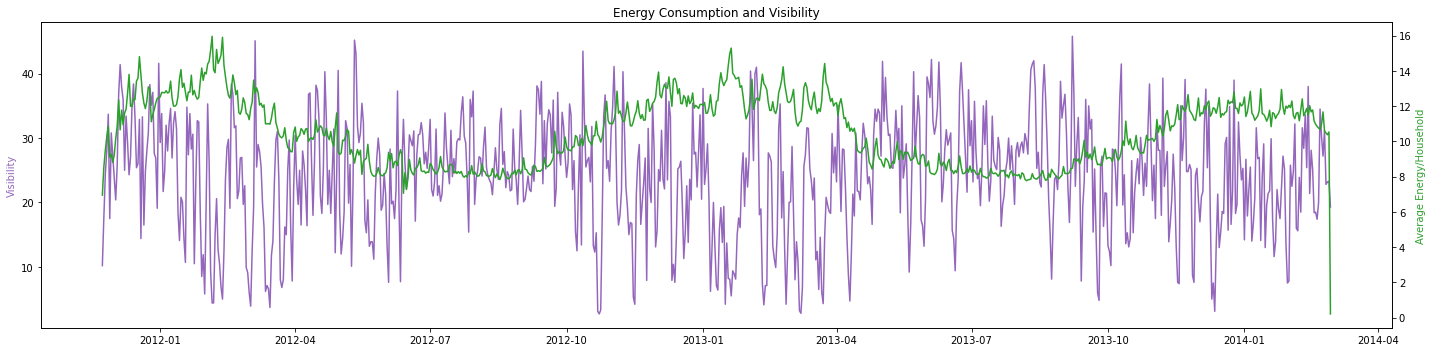

In [18]:
#Visibility vs Energy
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.Visibility, color = 'tab:Purple')
ax1.set_ylabel('Visibility',color = 'tab:Purple')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

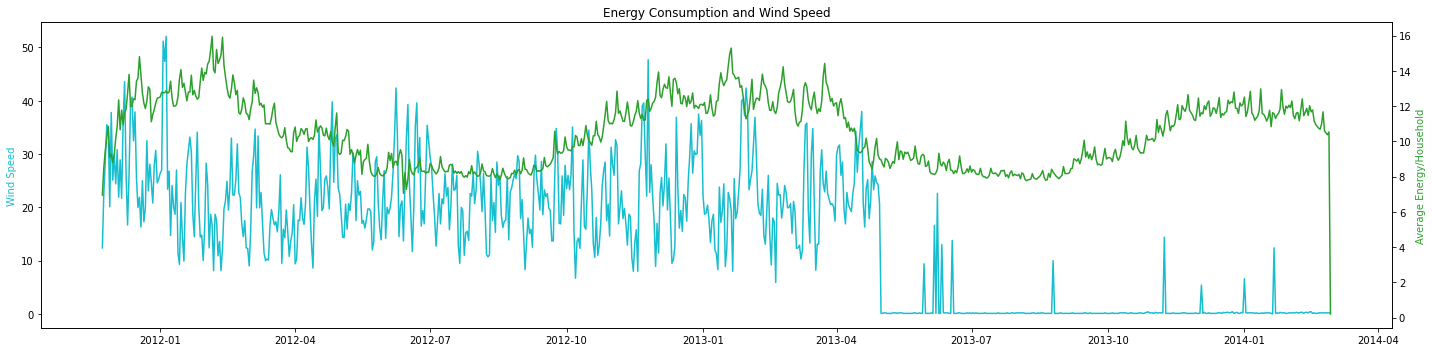

In [19]:
#Wind Speed vs Energy
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.Wind_Speed, color = 'tab:cyan')
ax1.set_ylabel('Wind Speed',color = 'tab:cyan')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

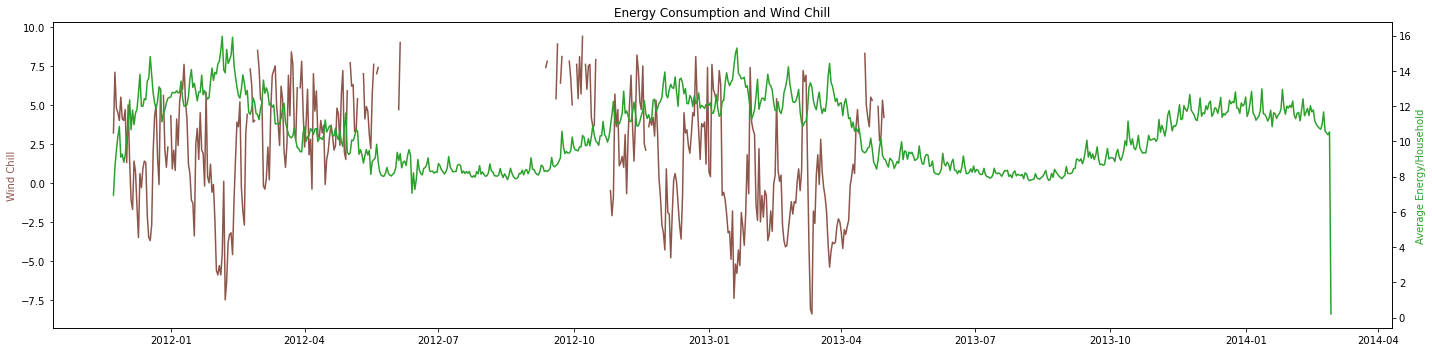

In [20]:
#Wind Chill vs Energy
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.Wind_Chill, color = 'tab:brown')
ax1.set_ylabel('Wind Chill',color = 'tab:brown')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Energy Consumption and Wind Chill')
fig.tight_layout()
plt.show()

In [21]:
cor_matrix = weather_energy[['avg_energy','Temperature','Visibility','Relative_Humidity']].corr()
cor_matrix

,avg_energy,Temperature,Visibility,Relative_Humidity
avg_energy,1.000000,-0.860203,-0.259971,0.396040
Temperature,-0.860203,1.000000,0.217270,-0.344378
Visibility,-0.259971,0.217270,1.000000,-0.549532
Relative_Humidity,0.396040,-0.344378,-0.549532,1.000000


In [22]:
#Creating weather Clusters 
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['Relative_Humidity','Visibility']])

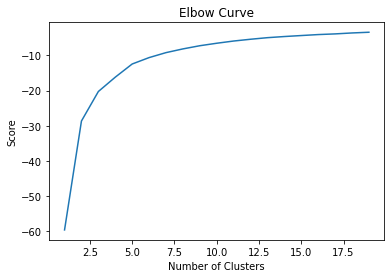

In [23]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [24]:
kmeans = KMeans(n_clusters=6, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)

KMeans(max_iter=600, n_clusters=6)

In [25]:
weather_energy['weather_cluster'] = kmeans.labels_

C:\Users\patri\anaconda3\lib\site-packages\matplotlib\collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


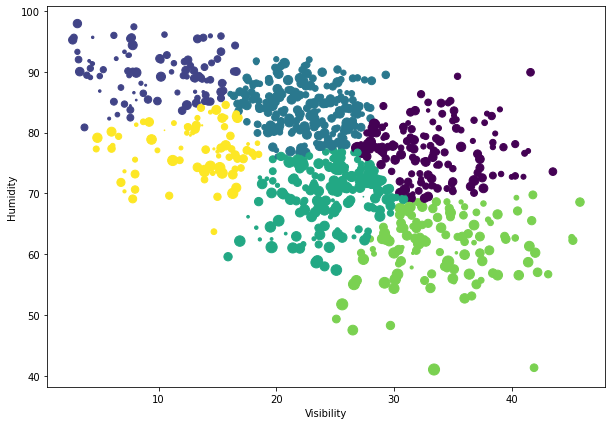

In [26]:
ig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.Visibility, 
            weather_energy.Relative_Humidity,
            s = weather_energy.Temperature*5,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Visibility')
ax1.set_ylabel('Humidity')
plt.show()

In [27]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

In [28]:
model_data = weather_energy[['avg_energy','Maximum_Temperature','Temperature','weather_cluster']]
training_set = model_data.iloc[0:(len(model_data)-60)]
dataset_test= model_data.iloc[len(training_set):(len(model_data)-1)]
dataset_train = weather_energy

In [29]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [30]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


In [32]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['Maximum_Temperature']= weather_energy.Maximum_Temperature.values[7:]

In [33]:


reframed = reframed.reindex(['weather_cluster', 'Maximum_Temperature','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values



In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [35]:


# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]



In [36]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [37]:


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(792, 1, 9) (792,) (30, 1, 9) (30,)


Epoch 1/50
11/11 - 12s - loss: 0.5751 - val_loss: 0.5048
Epoch 2/50
11/11 - 0s - loss: 0.4256 - val_loss: 0.3357
Epoch 3/50
11/11 - 0s - loss: 0.2627 - val_loss: 0.1442
Epoch 4/50
11/11 - 0s - loss: 0.1058 - val_loss: 0.0946
Epoch 5/50
11/11 - 0s - loss: 0.0855 - val_loss: 0.1191
Epoch 6/50
11/11 - 0s - loss: 0.0769 - val_loss: 0.0690
Epoch 7/50
11/11 - 0s - loss: 0.0679 - val_loss: 0.0589
Epoch 8/50
11/11 - 0s - loss: 0.0625 - val_loss: 0.0643
Epoch 9/50
11/11 - 0s - loss: 0.0593 - val_loss: 0.0599
Epoch 10/50
11/11 - 0s - loss: 0.0561 - val_loss: 0.0534
Epoch 11/50
11/11 - 0s - loss: 0.0533 - val_loss: 0.0519
Epoch 12/50
11/11 - 0s - loss: 0.0506 - val_loss: 0.0484
Epoch 13/50
11/11 - 0s - loss: 0.0481 - val_loss: 0.0466
Epoch 14/50
11/11 - 0s - loss: 0.0459 - val_loss: 0.0464
Epoch 15/50
11/11 - 0s - loss: 0.0440 - val_loss: 0.0446
Epoch 16/50
11/11 - 0s - loss: 0.0423 - val_loss: 0.0440
Epoch 17/50
11/11 - 0s - loss: 0.0408 - val_loss: 0.0437
Epoch 18/50
11/11 - 0s - loss: 0.0395 -

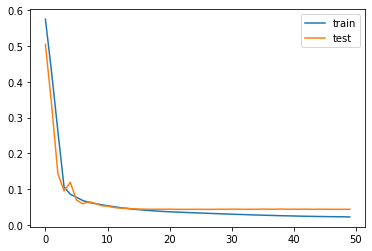

In [38]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:

# make a prediction
yhat = model.predict(test_X)

In [40]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [43]:


# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat = inv_yhat[:,0]

In [44]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]

In [48]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.624


In [71]:
predicted_lstm = pd.DataFrame({'predicted':inv_yhat,'avg_energy':inv_y})

In [74]:
predicted_lstm.drop(predicted_lstm.tail(1).index,
        inplace = True)

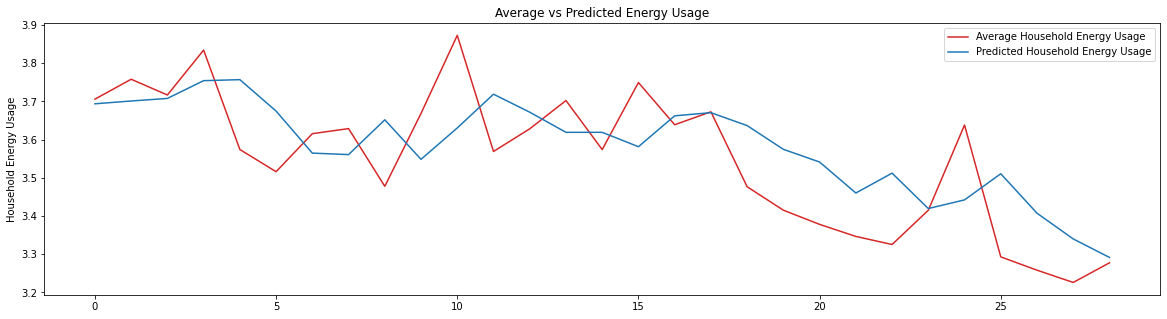

In [75]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(predicted_lstm['avg_energy'],color = 'tab:red',label='Average Household Energy Usage')
ax1.set_ylabel('Household Energy Usage')
ax1.plot(predicted_lstm['predicted'],color = 'tab:blue',label='Predicted Household Energy Usage')
plt.title('Average vs Predicted Energy Usage')
ax1.legend()
plt.show()

In [76]:
predicted_lstm

,predicted,avg_energy
0,3.693668,3.705790
1,3.700994,3.757952
2,3.707747,3.716657
3,3.754201,3.834259
4,3.756873,3.573996
5,3.674609,3.515900
6,3.564569,3.615430
7,3.560658,3.628714
8,3.651751,3.477669
9,3.548311,3.668540
